<a href="https://colab.research.google.com/github/sharhan-alhassan/zindi-crop-disease-detection/blob/main/Rail_Challenge_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Global Variables
test = True
production = True
unzip_data_from_drive = False        # For unzipping the images.zip file
import_datasets_from_drive = False   # Import datasets/ from drive

!pip install torch
import torch

cuda_available = torch.cuda.is_available()
cuda_available


True

In [3]:
# Always run
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# if import_datasets_from_drive:
#   print("Copying datasets/ from drive...")
#   !cp -r "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis/datasets" /content/datasets/
#   !rm /content/datasets/dataset/labels/train.cache
#   !rm /content/datasets/dataset/labels/val.cache
# else:
#   print("Proceeding to generate datasets/ later")



###################################### OPTIMIZE COPYING ######################################
import os
import shutil
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def fast_copy_tree(src, dst, buffer_size=10*1024*1024):  # 10MB buffer
    """Optimized directory tree copy with large buffer and parallel processing"""
    def copy_file_with_buffer(src_file, dst_file):
        try:
            with open(src_file, 'rb') as fsrc, open(dst_file, 'wb') as fdst:
                shutil.copyfileobj(fsrc, fdst, length=buffer_size)
            return True
        except Exception as e:
            print(f"Error copying {src_file}: {e}")
            return False

    def get_all_files(directory):
        files = []
        for dirpath, _, filenames in os.walk(directory):
            for f in filenames:
                src_path = Path(dirpath) / f
                dst_path = Path(dst) / Path(dirpath).relative_to(src) / f
                files.append((src_path, dst_path))
        return files

    # Create destination directory structure first
    for dirpath, dirnames, _ in os.walk(src):
        structure = Path(dst) / Path(dirpath).relative_to(src)
        os.makedirs(structure, exist_ok=True)

    # Get all files to copy
    file_pairs = get_all_files(src)
    total_files = len(file_pairs)

    # Use more workers for I/O operations
    max_workers = min(32, os.cpu_count() * 4)

    print(f"Copying {total_files} files with {max_workers} workers...")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for src_file, dst_file in file_pairs:
            futures.append(
                executor.submit(copy_file_with_buffer, src_file, dst_file)
            )

        # Show progress
        with tqdm(total=total_files, desc="Copying files") as pbar:
            for _ in as_completed(futures):
                pbar.update(1)

if import_datasets_from_drive:
    print("Copying datasets/ from drive with optimized parallel copy...")
    source_dir = Path("/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis/datasets")
    dest_dir = Path("/content/datasets")

    # Create destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # Perform optimized copy
    fast_copy_tree(source_dir, dest_dir)

    # Remove cache files after copy
    cache_files = [
        "/content/datasets/dataset/labels/train.cache",
        "/content/datasets/dataset/labels/val.cache"
    ]

    # Remove cache files if they exist
    for cache_file in cache_files:
        try:
            if os.path.exists(cache_file):
                os.remove(cache_file)
                print(f"Removed cache file: {cache_file}")
        except Exception as e:
            print(f"Error removing cache file {cache_file}: {e}")

    print("Copy completed and cache files removed.")
else:
    print("Proceeding to generate datasets/ later")


############################################################################

Proceeding to generate datasets/ later


In [20]:
if cuda_available:
  # Check GPU type
  !nvidia-smi
  import os
else:
  print("Skipping to use CPU")

Sun Nov  3 16:24:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
# Always run
# Install ultralytics
!pip -q install  ultralytics
!pip install aiofiles


In [22]:
# Always run
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
import multiprocessing

# Set the DATA_DIR to the directory where 'images.zip' is in
# Path to where your data is stored
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection')

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [23]:

####################################### ONE TIME DATA DOWNLOAD #######################################
if unzip_data_from_drive:
  from google.colab import auth
  auth.authenticate_user()

  # Set your Google Cloud project ID
  !gcloud config set project cloudbintech

  # # Ensure the destination directory exists
  # !mkdir -p "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/"

  # Install dependencies and compiled crcmod
  !sudo apt-get update
  !sudo apt-get install python3-dev python3-setuptools gcc -y
  !pip install --no-cache-dir -U crcmod

  # Copy the file from the bucket to the specified directory in Colab
  !gsutil -o 'GSUtil:parallel_composite_upload_threshold=150M' cp gs://zindi-crops-bucket/images.zip "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/"

  import os
  from pathlib import Path

  # Check if there is a temporary file and rename it
  for file in DATA_DIR.iterdir():
      if file.name.endswith('_.gstmp'):
          correct_name = file.with_suffix('')
          os.rename(file, correct_name)

  # Verify the file has the correct extension
  zip_path = DATA_DIR / 'images.zip'
  if not zip_path.exists():
      raise FileNotFoundError(f"{zip_path} not found")

  # Unzip the file
  import shutil
  shutil.unpack_archive(zip_path, 'images')

  # List the contents of the extracted directory
  extracted_dir = Path('images')
  print(os.listdir(extracted_dir))

  # Move the extracted directory to the destination directory in Google Drive
  !mv /content/images/ "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/"
else:
  print("Skipping using already unzipped data from Google drive")

Skipping using already unzipped data from Google drive


In [24]:
# Always run
# Add this check before copying
print("Load and Train Files")
images_dir = DATA_DIR / 'images'
if not images_dir.exists():
    print(f"Images directory not found at {images_dir}")
    print("Available contents in DATA_DIR:", os.listdir(DATA_DIR))
else:
    print(f"Images directory found at {images_dir}")

# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
# train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
# test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Modify these lines where you create the image_path
train['image_path'] = [DATA_DIR / 'images' / x for x in train.Image_ID]
test['image_path'] = [DATA_DIR / 'images' / x for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)


Load and Train Files
Images directory found at /content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/images


In [26]:
# Always run
from IPython.display import display

display(train.head())
display(train.count())

display(test.head())
display(test.count())

display(ss.head())
display(ss.count())


Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax  \
0   208.107730   341.967928   
1   162.910362   266.195724   
2   252.712993   338.876645   
3   238.593750   354.651316   
4  2184.252196  1401.748952   

                                          image_path  class_id  
0  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
1  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
2  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
3  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
4  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         8

Image_ID      41029
confidence    41029
class         41029
ymin          41029
xmin          41029
ymax          41029
xmax          41029
image_path    41029
class_id      41029
dtype: int64

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

                                          image_path  
0  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
1  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
2  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
3  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
4  /content/drive/MyDrive/Colab Notebooks/Zindi_C...

Image_ID      2101
confidence       0
class            0
ymin             0
xmin             0
ymax             0
xmax             0
image_path    2101
dtype: int64

Image_ID                      class  confidence  ymin  xmin  ymax  \
0  id_128pxx.jpg  Corn_Cercospora_Leaf_Spot         0.5   100   100   100   
1  id_128pxx.jpg           Corn_Common_Rust         0.5   100   100   100   
2  id_128pxx.jpg               Corn_Healthy         0.5   100   100   100   
3  id_128pxx.jpg  Corn_Northern_Leaf_Blight         0.5   100   100   100   
4  id_128pxx.jpg                Corn_Streak         0.5   100   100   100   

   xmax  
0   100  
1   100  
2   100  
3   100  
4   100

Image_ID      48323
class         48323
confidence    48323
ymin          48323
xmin          48323
ymax          48323
xmax          48323
dtype: int64

In [27]:
# Always run
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((30777, 9), (10252, 9))

In [28]:
# Always run
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Corn_Cercospora_Leaf_Spot    0.160444
 Tomato_Septoria              0.159047
 Tomato_Late_Blight           0.098905
 Corn_Streak                  0.077201
 Tomato_Healthy               0.069045
 Pepper_Septoria              0.051922
 Pepper_Leaf_Mosaic           0.051662
 Tomato_Early_Blight          0.047763
 Pepper_Bacterial_Spot        0.047665
 Corn_Common_Rust             0.040290
 Pepper_Leaf_Curl             0.037561
 Corn_Healthy                 0.037561
 Tomato_Fusarium              0.019950
 Pepper_Healthy               0.017935
 Pepper_Late_Blight           0.014296
 Pepper_Leaf_Blight           0.012574
 Tomato_Bacterial_Spot        0.011860
 Pepper_Cercospora            0.011405
 Pepper_Fusarium              0.011340
 Tomato_Leaf_Curl             0.011177
 Corn_Northern_Leaf_Blight    0.004289
 Tomato_Mosaic                0.003314
 Pepper_Early_Blight          0.002794
 Name: proportion, dtype: float64,
 class
 Corn_Cercospora_Leaf_Spot    0.156067
 Tomato_Septori

In [30]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
if not import_datasets_from_drive:
  for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
    if DIR.exists():
      shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok = True)
else:
  print("Skipping...not creating datasets/ but using those from drive")

In [14]:
# !rm -rf /content/runs/
!pip install aiofiles

In [44]:

# # Copy train, val and test images to their respective dirs
# if not import_datasets_from_drive:
#   for img in tqdm(X_train.image_path.unique()):
#       shutil.copy(str(img), TRAIN_IMAGES_DIR / img.name)  # Use img.name instead of img.parts[-1]

#   for img in tqdm(X_val.image_path.unique()):
#       shutil.copy(str(img), VAL_IMAGES_DIR / img.name)

#   for img in tqdm(test.image_path.unique()):
#       shutil.copy(str(img), TEST_IMAGES_DIR / img.name)
# else:
#   print("Skipping...not copyings images to datasets/ sub directories")


################################### OPTIMIZER 3 ###################################
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from pathlib import Path
import shutil
from tqdm import tqdm
import os
import numpy as np
from typing import List, Tuple, Union
import asyncio
import aiofiles
import io
import threading

class OptimizedFileCopier:
    def __init__(self, chunk_size: int = 1024 * 1024):  # 1MB chunks
        self.chunk_size = chunk_size
        self.lock = threading.Lock()

    async def async_copy_file(self, src: Union[str, Path], dest: Union[str, Path]) -> bool:
        try:
            async with aiofiles.open(str(src), 'rb') as fsrc:
                async with aiofiles.open(str(dest), 'wb') as fdst:
                    while True:
                        chunk = await fsrc.read(self.chunk_size)
                        if not chunk:
                            break
                        await fdst.write(chunk)
            return True
        except Exception as e:
            with self.lock:
                print(f"Error copying {src}: {e}")
            return False

    def batch_copy_files(self, file_pairs: List[Tuple[str, str]], batch_size: int = 100) -> List[bool]:
        async def process_batch(batch: List[Tuple[str, str]]) -> List[bool]:
            tasks = [self.async_copy_file(src, dest) for src, dest in batch]
            return await asyncio.gather(*tasks)

        results = []
        for i in range(0, len(file_pairs), batch_size):
            batch = file_pairs[i:i + batch_size]
            batch_results = asyncio.run(process_batch(batch))
            results.extend(batch_results)
        return results

def optimized_parallel_copy_files(
    source_files: List[Union[str, Path]],
    dest_dir: Union[str, Path],
    desc: str,
    max_workers: int = None,
    batch_size: int = 100
) -> None:
    # Determine optimal number of workers
    if max_workers is None:
        max_workers = min(32, multiprocessing.cpu_count() * 4)  # Increased from 8 to allow more concurrent I/O

    # Convert to Path objects and create destination directory
    dest_dir = Path(dest_dir)
    dest_dir.mkdir(parents=True, exist_ok=True)

    # Create file pairs and split into batches
    file_pairs = [(str(Path(img)), str(dest_dir / Path(img).name))
                  for img in source_files]

    # Initialize copier
    copier = OptimizedFileCopier()

    # Split work into batches for better progress tracking
    num_batches = (len(file_pairs) + batch_size - 1) // batch_size
    batches = np.array_split(file_pairs, num_batches)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit batch jobs
        futures = [
            executor.submit(copier.batch_copy_files, batch.tolist(), batch_size)
            for batch in batches
        ]

        # Show progress bar
        with tqdm(total=len(file_pairs), desc=desc) as pbar:
            for future in as_completed(futures):
                results = future.result()
                pbar.update(len(results))

# Main copying logic with optimizations
def main_copy_operation(import_datasets_from_drive, X_train, X_val, test):
    if not import_datasets_from_drive:
        # Create base directory structure
        for dir_name in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR]:
            os.makedirs(dir_name, exist_ok=True)

        # Process datasets in parallel
        datasets = [
            (X_train.image_path.unique(), TRAIN_IMAGES_DIR, "Copying training images"),
            (X_val.image_path.unique(), VAL_IMAGES_DIR, "Copying validation images"),
            (test.image_path.unique(), TEST_IMAGES_DIR, "Copying test images")
        ]

        # Process each dataset
        for source_files, dest_dir, desc in datasets:
            optimized_parallel_copy_files(
                source_files=source_files,
                dest_dir=dest_dir,
                desc=desc,
                batch_size=100  # Adjust based on average file size
            )
    else:
        print("Skipping...not copying images to datasets/ sub directories")

# First, define your directory constants
# TRAIN_IMAGES_DIR = "datasets/train"
# VAL_IMAGES_DIR = "datasets/val"
# TEST_IMAGES_DIR = "datasets/test"

# Then call the function with your data
main_copy_operation(
    import_datasets_from_drive,
    X_train,
    X_val,
    test
)
######################################################################

Current GPU Status:
Sun Nov  3 17:04:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              31W /  70W |    239MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-----

Copying test images: 100%|██████████| 2101/2101 [02:56<00:00, 11.89it/s]


In [45]:
X_train.head()

Image_ID  confidence                      class        ymin  \
0  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  194.649671   
1  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  149.632401   
2  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  234.046875   
3  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  221.277138   
6  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  774.562500   

          xmin        ymax         xmax  \
0   328.803454  208.107730   341.967928   
1   256.768914  162.910362   266.195724   
2   327.138158  252.712993   338.876645   
3   340.411184  238.593750   354.651316   
6  2735.933839  850.476742  2834.348725   

                                          image_path  class_id  
0  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
1  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
2  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
3  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
6  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         0

In [36]:
# import multiprocessing
# from pathlib import Path
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# import shutil
# import pandas as pd

# if not import_datasets_from_drive:
#   # Function to convert the bboxes to YOLO format
#   def convert_to_yolo(bbox, width, height):
#       ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
#       class_id = bbox['class_id']

#       # Normalize the coordinates
#       x_center = (xmin + xmax) / 2 / width
#       y_center = (ymin + ymax) / 2 / height
#       bbox_width = (xmax - xmin) / width
#       bbox_height = (ymax - ymin) / height

#       return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

#   # Top-level function to save annotations for a single image
#   def save_yolo_annotations_task(task):
#       image_path, bboxes, output_dir = task
#       try:
#           img = np.array(Image.open(str(image_path)))
#           height, width, _ = img.shape
#       except Exception as e:
#           print(f"Error opening image {image_path}: {e}")
#           return

#       label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
#       with open(label_file, 'w') as f:
#           for bbox in bboxes:
#               annotation = convert_to_yolo(bbox, width, height)
#               f.write(f"{annotation}\n")

#   # Function to clear output directory
#   def clear_output_dir(output_dir):
#       if Path(output_dir).exists():
#           shutil.rmtree(output_dir)
#       Path(output_dir).mkdir(parents=True, exist_ok=True)

#   # Function to process the dataset and save annotations
#   def process_dataset(dataframe, output_dir):
#       # Clear the output directory to prevent duplicate annotations
#       clear_output_dir(output_dir)

#       # Group the DataFrame by 'image_path'
#       grouped = dataframe.groupby('image_path')
#       tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

#       # Use multiprocessing Pool to process tasks
#       with multiprocessing.Pool() as pool:
#           list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


#   # Save train and validation labels to their respective dirs
#   process_dataset(X_train, TRAIN_LABELS_DIR)
#   process_dataset(X_val, VAL_LABELS_DIR)
# else:
#   print("Skipping processing of datasets/")



########################### AGGRESSIVE OPTIMIZATION #############################
import multiprocessing
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd
import psutil
import mmap
import io
from concurrent.futures import ThreadPoolExecutor
import os

if not import_datasets_from_drive:
    def get_optimal_chunk_size():
        """Calculate optimal chunk size based on available RAM"""
        available_ram = psutil.virtual_memory().available
        return max(100, int(available_ram / (1024 * 1024 * 250)))  # Allocate ~250MB per image

    def convert_to_yolo(bbox, width, height):
        """Vectorized YOLO conversion"""
        ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
        class_id = bbox['class_id']

        # Normalize coordinates using numpy for speed
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

    def process_image_batch(batch_data):
        """Process a batch of images with optimized memory usage"""
        output_dir, image_paths, bbox_groups = batch_data

        # Pre-allocate memory for batch processing
        results = []

        for img_path, bboxes in zip(image_paths, bbox_groups):
            try:
                # Use PIL's lazy loading to reduce memory usage
                with Image.open(str(img_path)) as img:
                    width, height = img.size

                # Process annotations
                annotations = [convert_to_yolo(bbox, width, height) for bbox in bboxes]

                # Write annotations to file using buffered I/O
                label_file = Path(output_dir) / f"{Path(img_path).stem}.txt"
                with io.StringIO() as buffer:
                    buffer.writelines(f"{annotation}\n" for annotation in annotations)
                    with open(label_file, 'w') as f:
                        f.write(buffer.getvalue())

                results.append(True)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                results.append(False)

        return results

    def clear_output_dir(output_dir):
        """Efficiently clear output directory"""
        if Path(output_dir).exists():
            shutil.rmtree(output_dir)
        os.makedirs(output_dir, exist_ok=True)

    def process_dataset(dataframe, output_dir):
        """Process dataset with optimized memory usage and parallel processing"""
        print(f"\nProcessing dataset for {output_dir}")
        print(f"Initial RAM Usage: {psutil.virtual_memory().percent}%")

        # Clear output directory
        clear_output_dir(output_dir)

        # Group the DataFrame by image_path
        grouped = dataframe.groupby('image_path')

        # Calculate optimal batch size based on available RAM
        batch_size = get_optimal_chunk_size()

        # Prepare batches
        image_paths = []
        bbox_groups = []
        for img_path, group in grouped:
            image_paths.append(img_path)
            bbox_groups.append(group.to_dict('records'))

        # Create batches
        total_images = len(image_paths)
        batches = []
        for i in range(0, total_images, batch_size):
            batch_end = min(i + batch_size, total_images)
            batches.append((
                output_dir,
                image_paths[i:batch_end],
                bbox_groups[i:batch_end]
            ))

        # Calculate optimal number of processes
        cpu_count = os.cpu_count()
        available_ram = psutil.virtual_memory().available
        ram_based_processes = max(1, int(available_ram / (1024 * 1024 * 1024)))  # 1GB per process
        num_processes = min(cpu_count, ram_based_processes, len(batches))

        print(f"\nProcessing Configuration:")
        print(f"Batch Size: {batch_size} images")
        print(f"Number of Processes: {num_processes}")
        print(f"Total Batches: {len(batches)}")

        # Process batches in parallel
        with multiprocessing.Pool(processes=num_processes) as pool:
            with tqdm(total=total_images, desc="Processing images") as pbar:
                for batch_results in pool.imap_unordered(process_image_batch, batches):
                    pbar.update(len(batch_results))
                    # Update RAM usage in progress description
                    ram_usage = psutil.virtual_memory().percent
                    pbar.set_description(f"Processing images (RAM: {ram_usage}%)")

        print(f"Final RAM Usage: {psutil.virtual_memory().percent}%")

    # Install psutil if not present
    try:
        import psutil
    except ImportError:
        print("Installing psutil...")
        !pip install psutil
        import psutil

    # Process train and validation datasets
    print("\nStarting dataset processing...")
    process_dataset(X_train, TRAIN_LABELS_DIR)
    process_dataset(X_val, VAL_LABELS_DIR)

else:
    print("Skipping processing of datasets/")

#################################################################################


Starting dataset processing...

Processing dataset for datasets/dataset/labels/train
Initial RAM Usage: 16.1%

Processing Configuration:
Batch Size: 100 images
Number of Processes: 2
Total Batches: 37


Processing images (RAM: 16.5%): 100%|██████████| 3676/3676 [06:29<00:00,  9.44it/s]


Final RAM Usage: 16.1%

Processing dataset for datasets/dataset/labels/val
Initial RAM Usage: 16.1%

Processing Configuration:
Batch Size: 100 images
Number of Processes: 2
Total Batches: 13


Processing images (RAM: 16.2%): 100%|██████████| 1226/1226 [08:08<00:00,  2.51it/s]

Final RAM Usage: 16.2%


In [37]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [39]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': '/content/' + str(TRAIN_IMAGES_DIR),
    'val': '/content/' + str(VAL_IMAGES_DIR),
    'test': '/content/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/content/datasets/dataset/images/train',
 'val': '/content/datasets/dataset/images/val',
 'test': '/content/datasets/dataset/images/test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_uzrdfu.jpg with 7 bounding boxes.


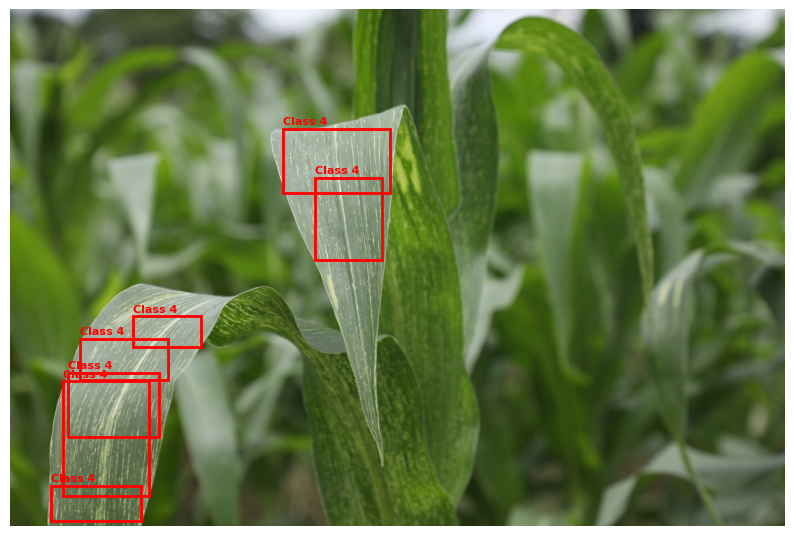

Plotting id_yeilzs.jpg with 11 bounding boxes.


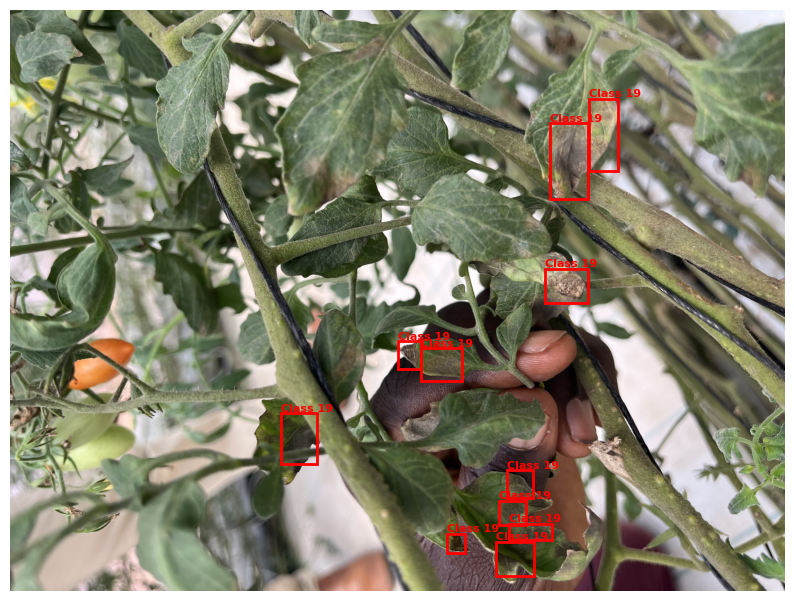

Plotting id_o1g2nf.jpg with 6 bounding boxes.


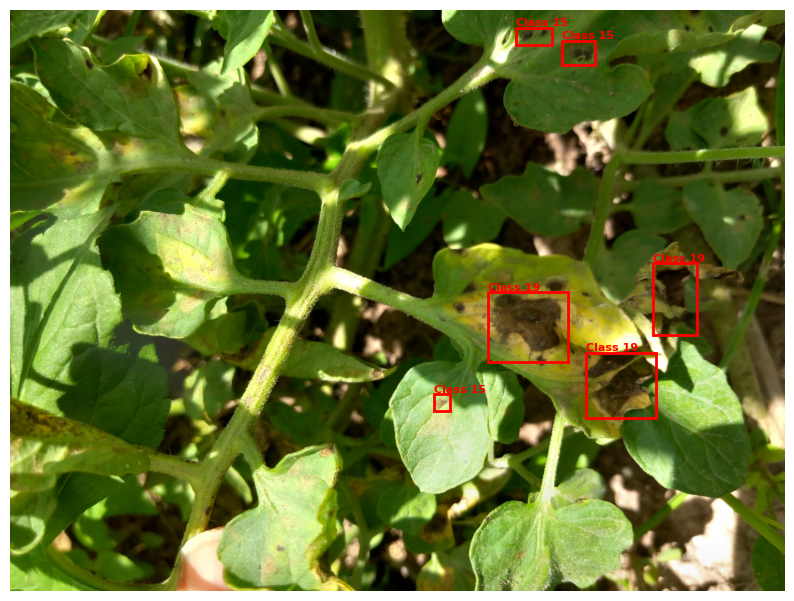

Plotting id_zojjxe.jpg with 4 bounding boxes.


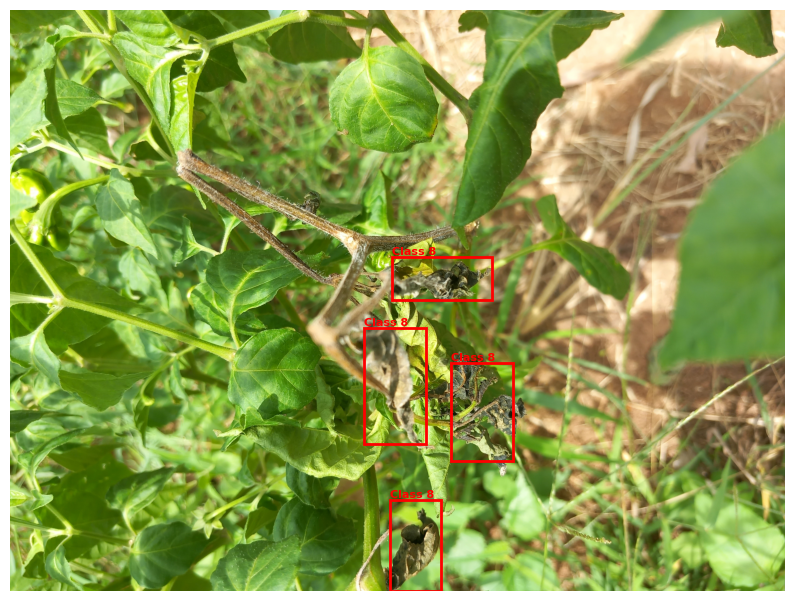

Plotting id_tz4oza.jpg with 3 bounding boxes.


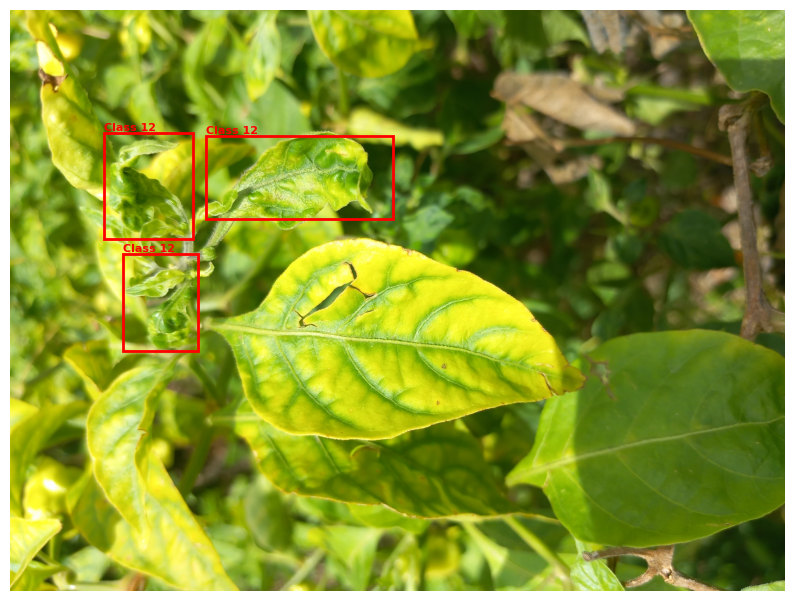

In [40]:
# Always run
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [5]:
# Always run
# Install ultralytics
!pip -q install  ultralytics
!pip install aiofiles

In [6]:
# # Load a yolo pretrained model
# if cuda_available:
#   device_type = 0
# else:
#   device_type = 'cpu'

# model = YOLO('yolov8n.pt')
# # Ultra-fast testing setup
# model.train(
#     data='data.yaml',
#     epochs=2,                  # Just 1 epoch
#     imgsz=1024,                # Even smaller image size
#     batch=32,                 # Larger batch size
#     device=device_type,
#     patience=2,
#     workers=8,
#     cache=True,
#     pretrained=True,
#     optimizer='AdamW'
# )



# # Fine tune model to our data
# model.train(
#     data='data.yaml',          # Path to the dataset configuration
#     epochs=10,                 # Number of epochs
#     imgsz=1024,                # Image size (height, width)
#     batch=8,                   # Batch size
#     device=0,                  # Device to use (0 for the first GPU)
#     patience=5)


# # Load a yolo pretrained model
# model = YOLO('yolov8n.pt')  # Using the smallest YOLO model 'nano'

# # Fine tune model with faster settings for testing
# model.train(
#     data='data.yaml',
#     epochs=2,                  # Reduced from 10 to 2 epochs
#     imgsz=640,                # Reduced image size from 1024 to 640
#     batch=16,                 # Increased batch size from 8 to 16 (faster processing)
#     device=0,
#     patience=2,               # Reduced patience from 5 to 2
#     workers=8,                # Add worker threads for faster data loading
#     cache=True,               # Cache images in RAM for faster training
#     pretrained=True,          # Use pretrained weights
#     optimizer='AdamW'         # Faster optimizer
# )


# # Production-optimized training configuration
# model.train(
#     data='data.yaml',
#     epochs=100,                # Increased for better convergence
#     imgsz=640,                # Standard YOLO image size for optimal accuracy
#     batch=64,                 # Increased batch size for better GPU utilization
#     device=0,                 # Single GPU (use device=[0,1,2,3] for multi-GPU)
#     patience=20,              # Early stopping patience - prevents overfitting
#     workers=16,               # Increased workers for faster data loading
#     cache=True,              # Cache images in RAM for faster training
#     pretrained=True,         # Use pretrained weights
#     optimizer='AdamW',       # AdamW optimizer for better convergence
#     cos_lr=True,             # Cosine learning rate scheduler
#     label_smoothing=0.1,     # Reduces overfitting
#     warmup_epochs=3,         # Warm up learning rate
#     weight_decay=0.001,      # L2 regularization
#     overlap_mask=True,       # Better mask prediction
#     close_mosaic=10,         # Disable mosaic augmentation in final epochs
#     amp=True,                # Automatic mixed precision for faster training
#     multi_scale=True,        # Multi-scale training for better generalization
#     save_period=10,          # Save checkpoints every 10 epochs
#     nbs=64                   # Nominal batch size for gradient accumulation
# )


# Optimize model to use GPU
import torch
import os
import numpy as np
from IPython.display import clear_output
from ultralytics import YOLO

# First, verify GPU availability and get details
def setup_gpu():
    if torch.cuda.is_available():
        # Clear GPU cache
        torch.cuda.empty_cache()

        # Get GPU information
        gpu_info = !nvidia-smi
        print("GPU Information:")
        for line in gpu_info:
            print(line)

        # Set environment variables for better performance
        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

        # Enable memory pinning
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.enabled = True

        # Set device
        device = torch.device('cuda:0')
        device_type = 0

        # Print memory status
        print("\nInitial GPU Memory Usage:")
        print(torch.cuda.memory_summary())

        return device, device_type
    else:
        print("No GPU available. Using CPU.")
        return torch.device('cpu'), 'cpu'

# Function to monitor GPU usage
def monitor_gpu():
    gpu_info = !nvidia-smi
    clear_output(wait=True)
    print("Current GPU Status:")
    for line in gpu_info:
        print(line)

# Modified YOLO training setup
def setup_yolo_training():
    device, device_type = setup_gpu()

    # Load model with optimized settings
    model = YOLO('yolov8n.pt')

    # Advanced training configuration
    training_args = {
        'data': 'data.yaml',
        'epochs': 2,
        'imgsz': 1024,
        'batch': 32,
        'device': device_type,
        'patience': 2,
        'workers': 8,
        'cache': 'disk', # True
        'pretrained': True,
        'optimizer': 'AdamW',
        # Additional optimization parameters
        'amp': True,  # Automatic Mixed Precision
        'rect': True,  # Rectangular training
        'cos_lr': True,  # Cosine LR scheduler
        'overlap_mask': True,  # Mask overlap during training
        'profile': True,  # Profile CUDA operations
        'multi_scale': True,  # Multi-scale training
        'degrees': 10.0,  # Image rotation augmentation
        'translate': 0.1,  # Image translation augmentation
        'scale': 0.5,  # Image scale augmentation
        'mosaic': 1.0,  # Mosaic augmentation
    }

    return model, training_args

# Set up model and training
model, training_args = setup_yolo_training()

# Optional: Set up GPU monitoring
from threading import Thread
import time

def gpu_monitor_thread():
    while True:
        monitor_gpu()
        time.sleep(60)  # Update every minute

# Start GPU monitoring in background
monitor_thread = Thread(target=gpu_monitor_thread, daemon=True)
monitor_thread.start()

# Start training with optimized parameters
try:
    model.train(**training_args)
except RuntimeError as e:
    print(f"Error during training: {e}")
    # If OOM error, try reducing batch size
    if "out of memory" in str(e):
        print("Reducing batch size and retrying...")
        training_args['batch'] //= 2
        torch.cuda.empty_cache()
        model.train(**training_args)

Current GPU Status:
Sun Nov  3 17:30:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              32W /  70W |  13643MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-----

  0%|          | 0/230 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 249905 has 14.73 GiB memory in use. Of the allocated memory 14.36 GiB is allocated by PyTorch, and 210.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Validate the model on the validation set
model = YOLO('/content/runs/detect/train/weights/best.pt')
results = model.val()

In [ ]:
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


def validate_submission(submission_df, sample_submission_df):
    """
    Validate the submission DataFrame against the sample submission format.
    """
    print("\nValidating submission...")

    # Check for missing images
    missing_ids = set(sample_submission_df['Image_ID']) - set(submission_df['Image_ID'])
    if missing_ids:
        print(f"Error: Missing {len(missing_ids)} required Image_IDs")
        print("First few missing:", list(missing_ids)[:5])

    # Check column names
    expected_columns = set(sample_submission_df.columns)
    actual_columns = set(submission_df.columns)
    if expected_columns != actual_columns:
        print("Error: Column mismatch")
        print("Missing columns:", expected_columns - actual_columns)
        print("Extra columns:", actual_columns - expected_columns)

    # Check prediction counts
    expected_count = len(sample_submission_df)
    actual_count = len(submission_df)
    print(f"Submission has {actual_count} rows, expected {expected_count}")

    return len(missing_ids) == 0

def analyze_and_setup_parameters(train_df, model, test_dir_path):
    """
    Analyze training data and model predictions to determine optimal parameters
    """
    # Get class distribution
    class_distribution = train_df['class'].value_counts()
    default_class = class_distribution.index[0]

    print("Class distribution in training data:")
    print(class_distribution)
    print(f"\nUsing {default_class} as default class")

    # Analyze confidence scores
    image_files = os.listdir(test_dir_path)
    confidences = []

    print("\nAnalyzing model confidence scores...")
    for image_file in tqdm(image_files[:50]):  # Sample first 50 images
        img_path = os.path.join(test_dir_path, image_file)
        results = model(img_path)
        if len(results[0].boxes) > 0:
            confidences.extend(results[0].boxes.conf.tolist())

    if confidences:
        median_confidence = np.median(confidences)
        suggested_threshold = max(0.1, median_confidence * 0.5)  # Set threshold to 50% of median confidence
        print(f"\nSuggested confidence threshold: {suggested_threshold:.3f}")
    else:
        suggested_threshold = 0.1
        print("\nNo detections found in sample, using default threshold: 0.1")

    return default_class, suggested_threshold

def process_test_predictions(model, test_df, test_dir_path, train_df):
    """
    Process all test images with dynamically determined parameters
    """
    # Get optimal parameters
    default_class, confidence_threshold = analyze_and_setup_parameters(
        train_df, model, test_dir_path
    )

    all_predictions = []
    required_images = set(test_df['Image_ID'])
    processed_images = set()

    print(f"\nProcessing {len(required_images)} test images...")

    for image_id in tqdm(required_images):
        img_path = os.path.join(test_dir_path, image_id)

        try:
            if not os.path.exists(img_path):
                print(f"Warning: Image not found: {image_id}")
                all_predictions.append({
                    'Image_ID': image_id,
                    'class': default_class,
                    'confidence': confidence_threshold,
                    'ymin': 0,
                    'xmin': 0,
                    'ymax': 1,
                    'xmax': 1
                })
                continue

            results = model(img_path)
            processed_images.add(image_id)

            valid_detections = False

            if len(results[0].boxes) > 0:
                boxes = results[0].boxes.xyxy.tolist()
                classes = results[0].boxes.cls.tolist()
                confidences = results[0].boxes.conf.tolist()

                for box, cls, conf in zip(boxes, classes, confidences):
                    if conf >= confidence_threshold:
                        valid_detections = True
                        x1, y1, x2, y2 = box
                        detected_class = results[0].names[int(cls)]

                        all_predictions.append({
                            'Image_ID': image_id,
                            'class': detected_class,
                            'confidence': float(conf),
                            'ymin': float(y1),
                            'xmin': float(x1),
                            'ymax': float(y2),
                            'xmax': float(x2)
                        })

            if not valid_detections:
                all_predictions.append({
                    'Image_ID': image_id,
                    'class': default_class,
                    'confidence': confidence_threshold,
                    'ymin': 0,
                    'xmin': 0,
                    'ymax': 1,
                    'xmax': 1
                })

        except Exception as e:
            print(f"Error processing image {image_id}: {str(e)}")
            all_predictions.append({
                'Image_ID': image_id,
                'class': default_class,
                'confidence': confidence_threshold,
                'ymin': 0,
                'xmin': 0,
                'ymax': 1,
                'xmax': 1
            })

    predictions_df = pd.DataFrame(all_predictions)

    # Print summary
    print("\nPrediction Summary:")
    print(f"Total images processed: {len(processed_images)}")
    print(f"Total predictions made: {len(predictions_df)}")
    print("\nPredictions per class:")
    print(predictions_df['class'].value_counts())

    return predictions_df

# Load your data and model
# model = YOLO('/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis/runs/detect/train/weights/best.pt')
model = YOLO('/content/runs/detect/train/weights/best.pt')

train_df = pd.read_csv(DATA_DIR / 'Train.csv')
test_df = pd.read_csv(DATA_DIR / 'Test.csv')
sample_submission = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Process test predictions
predictions_df = process_test_predictions(
    model=model,
    test_df=test_df,
    test_dir_path='/content/datasets/dataset/images/test',
    train_df=train_df
)

# Validate the predictions
is_valid = validate_submission(predictions_df, sample_submission)

if is_valid:
    # Save the submission file
    predictions_df.to_csv('submission_01.csv', index=False)
    print("Submission file created successfully!")
else:
    print("Please fix the validation errors before saving the submission.")

In [ ]:
predictions_df.head()

In [ ]:
predictions_df['class'].value_counts()

In [ ]:
!cp /content/submission_01.csv/ '/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection'

In [4]:
import shutil
from pathlib import Path

# Define source and destination directories
source_dirs = ['/content/runs/', '/content/datasets/']
destination_base_dir = Path('/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis')

# Function to get the next available directory name with incrementing number
def get_next_available_directory(base_dir):
    if not base_dir.exists():
        return base_dir
    i = 1
    while True:
        new_dir = base_dir.parent / f"{base_dir.name}_{i:02d}"
        if not new_dir.exists():
            return new_dir
        i += 1

# Get the next available analysis directory
destination_dir = get_next_available_directory(destination_base_dir)

# Create the destination directory if it does not exist
destination_dir.mkdir(parents=True, exist_ok=True)

# Copy each source directory to the destination
for source_dir in source_dirs:
    dest_dir = destination_dir / Path(source_dir).name
    shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)

print(f"Files copied to: {destination_dir}")

Files copied to: /content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis_01
